# QVM Engine v3j Long-Only Real Data Strategy with Enhanced Regime Detection

This strategy uses REAL data with improved regime-adjusted QVM factor integration.

## Key Features
- Long-only strategy with 20 stocks and dynamic position sizing
- Real price data from 2016-2025
- Enhanced regime detection with stability controls (30-day lookback, 5-day minimum duration)
- Dynamic factor weighting and allocation based on market regime:
  * Normal: Equal weighting (33% Q + 33% V + 34% M) with 100% allocation
  * Stress: Quality-focused (40% Q + 30% V + 30% M) with 60% allocation (defensive - sell across all positions)
  * Bull: Momentum-focused (15% Q + 35% V + 50% M) with 100% allocation
- Monthly rebalancing with transaction costs
- Comprehensive performance analysis and visualization

# IMPORTS AND SETUP

In [27]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add Project Root to Python Path
current_path = Path.cwd()
while not (current_path / 'production').is_dir():
    if current_path.parent == current_path:
        raise FileNotFoundError("Could not find the 'production' directory.")
    current_path = current_path.parent

project_root = current_path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from production.database.connection import get_database_manager

print("✅ Libraries imported and project path configured")

✅ Libraries imported and project path configured


# STRATEGY CONFIGURATION

In [28]:
# LONG-ONLY REAL DATA STRATEGY CONFIGURATION
QVM_CONFIG = {
    "strategy_name": "QVM_Engine_v3j_Long_Only_Real_Data_Regime_Adjusted_v2",
    "backtest_start_date": "2016-01-01",
    "backtest_end_date": "2025-12-31",  # Extended to include 2024-2025 data
    "rebalance_frequency": "M",  # Monthly rebalancing
    "transaction_cost_bps": 30,  # 30 basis points transaction costs
    "universe": {
        "lookback_days": 63,  # ~3 months for momentum calculation
        "top_n_stocks": 200,  # Top 200 stocks by liquidity
        "target_portfolio_size": 20,  # Equal-weighted portfolio of 20 stocks
    },
    "regime_detection": {
        "lookback_days": 30,  # Shorter regime detection window (30 days)
        "volatility_threshold": 0.75,  # 75th percentile for high volatility (conservative)
        "return_threshold": 0.25,  # 25th percentile for low returns (conservative)
        "bull_return_threshold": 0.75,  # 75th percentile for high returns (bull regime)
        "min_regime_duration": 5,  # Minimum days to stay in a regime (reduce volatility)
    },
    "factor_weights": {
        "normal": {"quality": 0.33, "value": 0.33, "momentum": 0.34},  # Equal weighting
        "stress": {"quality": 0.4, "value": 0.3, "momentum": 0.3, "allocation": 0.6},  # 60% allocation, quality-focused
        "bull": {"quality": 0.15, "value": 0.35, "momentum": 0.5, "allocation": 1.0},  # Reduce quality, increase momentum
    },
    "strategy_type": "long_only_regime_adjusted_v2",
}

print("📋 Strategy Configuration:")
for key, value in QVM_CONFIG.items():
    if key == "universe":
        print(f"  {key}:")
        for subkey, subvalue in value.items():
            print(f"    {subkey}: {subvalue}")
    elif key == "regime_detection":
        print(f"  {key}:")
        for subkey, subvalue in value.items():
            print(f"    {subkey}: {subvalue}")
    elif key == "factor_weights":
        print(f"  {key}:")
        for regime, weights in value.items():
            print(f"    {regime}: {weights}")
    else:
        print(f"  {key}: {value}")

📋 Strategy Configuration:
  strategy_name: QVM_Engine_v3j_Long_Only_Real_Data_Regime_Adjusted_v2
  backtest_start_date: 2016-01-01
  backtest_end_date: 2025-12-31
  rebalance_frequency: M
  transaction_cost_bps: 30
  universe:
    lookback_days: 63
    top_n_stocks: 200
    target_portfolio_size: 20
  regime_detection:
    lookback_days: 30
    volatility_threshold: 0.75
    return_threshold: 0.25
    bull_return_threshold: 0.75
    min_regime_duration: 5
  factor_weights:
    normal: {'quality': 0.33, 'value': 0.33, 'momentum': 0.34}
    stress: {'quality': 0.4, 'value': 0.3, 'momentum': 0.3, 'allocation': 0.6}
    bull: {'quality': 0.15, 'value': 0.35, 'momentum': 0.5, 'allocation': 1.0}
  strategy_type: long_only_regime_adjusted_v2


# DATA LOADING FUNCTIONS

In [29]:
def create_db_connection():
    """Create database connection."""
    try:
        db_manager = get_database_manager()
        engine = db_manager.get_engine()
        print("✅ Database connection established")
        return engine
    except Exception as e:
        print(f"❌ Database connection failed: {e}")
        raise

def load_real_price_data(db_engine, start_date, end_date):
    """Load REAL price data with returns."""
    print(f"📊 Loading REAL price data from {start_date} to {end_date}...")
    
    query = f"""
    SELECT 
        trading_date as date,
        ticker,
        close_price_adjusted as close_price,
        total_volume as volume,
        market_cap,
        (close_price_adjusted * total_volume) as daily_value
    FROM vcsc_daily_data_complete
    WHERE trading_date >= '{start_date}' AND trading_date <= '{end_date}'
    ORDER BY trading_date, ticker
    """
    
    try:
        data = pd.read_sql(query, db_engine)
        data['date'] = pd.to_datetime(data['date'])
        
        # Calculate daily returns
        data = data.sort_values(['ticker', 'date'])
        data['return'] = data.groupby('ticker')['close_price'].pct_change()
        
        print(f"   ✅ Loaded {len(data):,} price records")
        print(f"   📈 Date range: {data['date'].min()} to {data['date'].max()}")
        print(f"   🏢 Unique tickers: {data['ticker'].nunique()}")
        print(f"   📊 Average daily return: {data['return'].mean():.4f}")
        
        return data
        
    except Exception as e:
        print(f"   ❌ Failed to load price data: {e}")
        return pd.DataFrame()

def load_real_factor_scores(db_engine, start_date, end_date):
    """Load REAL factor scores including all QVM components."""
    print(f"📊 Loading REAL factor scores from {start_date} to {end_date}...")
    
    query = f"""
    SELECT 
        date,
        ticker,
        Quality_Composite,
        Value_Composite,
        Momentum_Composite,
        QVM_Composite
    FROM factor_scores_qvm
    WHERE date >= '{start_date}' AND date <= '{end_date}'
    ORDER BY date, ticker
    """
    
    try:
        data = pd.read_sql(query, db_engine)
        data['date'] = pd.to_datetime(data['date'])
        print(f"   ✅ Loaded {len(data):,} factor score records")
        print(f"   📈 Date range: {data['date'].min()} to {data['date'].max()}")
        print(f"   🏢 Unique tickers: {data['ticker'].nunique()}")
        return data
        
    except Exception as e:
        print(f"   ❌ Failed to load factor scores: {e}")
        return pd.DataFrame()

def load_real_benchmark_data(db_engine, start_date, end_date):
    """Load REAL benchmark data."""
    print(f"📊 Loading REAL benchmark data from {start_date} to {end_date}...")
    
    query = f"""
    SELECT 
        date,
        close as close_price
    FROM etf_history
    WHERE ticker = 'VNINDEX' 
    AND date >= '{start_date}' AND date <= '{end_date}'
    ORDER BY date
    """
    
    try:
        data = pd.read_sql(query, db_engine)
        data['date'] = pd.to_datetime(data['date'])
        data = data.sort_values('date')
        data['return'] = data['close_price'].pct_change()
        data['cumulative_return'] = (1 + data['return']).cumprod()
        
        print(f"   ✅ Loaded {len(data)} benchmark records")
        return data
        
    except Exception as e:
        print(f"   ❌ Failed to load benchmark data: {e}")
        return pd.DataFrame()

print("✅ Data loading functions defined")

✅ Data loading functions defined


# REGIME DETECTION AND FACTOR INTEGRATION

In [30]:
def detect_market_regime(benchmark_data, config):
    """Detect market regime based on benchmark performance with stability controls."""
    print("📊 Detecting market regime with stability controls...")
    
    lookback_days = config['regime_detection']['lookback_days']
    vol_threshold_pct = config['regime_detection']['volatility_threshold']
    return_threshold_pct = config['regime_detection']['return_threshold']
    bull_return_threshold_pct = config['regime_detection']['bull_return_threshold']
    min_regime_duration = config['regime_detection']['min_regime_duration']
    
    # Calculate rolling volatility and returns
    benchmark_data = benchmark_data.sort_values('date')
    benchmark_data['rolling_vol'] = benchmark_data['return'].rolling(lookback_days).std() * np.sqrt(252)
    benchmark_data['rolling_return'] = benchmark_data['return'].rolling(lookback_days).mean() * 252
    
    # Define regime thresholds
    vol_threshold = benchmark_data['rolling_vol'].quantile(vol_threshold_pct)
    return_threshold = benchmark_data['rolling_return'].quantile(return_threshold_pct)
    bull_return_threshold = benchmark_data['rolling_return'].quantile(bull_return_threshold_pct)
    
    # Initial regime classification
    benchmark_data['regime'] = 'normal'
    benchmark_data.loc[
        (benchmark_data['rolling_vol'] > vol_threshold) & 
        (benchmark_data['rolling_return'] < return_threshold), 'regime'
    ] = 'stress'
    benchmark_data.loc[
        (benchmark_data['rolling_vol'] < vol_threshold) & 
        (benchmark_data['rolling_return'] > bull_return_threshold), 'regime'
    ] = 'bull'
    
    # Apply minimum regime duration filter to reduce volatility
    print(f"   📊 Applying minimum regime duration filter ({min_regime_duration} days)...")
    
    # Forward fill regimes to ensure minimum duration
    benchmark_data['regime_stable'] = benchmark_data['regime']
    
    # Use rolling window to smooth regime changes
    for i in range(min_regime_duration, len(benchmark_data)):
        # Check if we have enough consecutive days in the same regime
        recent_regimes = benchmark_data['regime'].iloc[i-min_regime_duration+1:i+1]
        if len(recent_regimes.unique()) == 1:
            # Stable regime, keep it
            benchmark_data.iloc[i, benchmark_data.columns.get_loc('regime_stable')] = recent_regimes.iloc[0]
        else:
            # Unstable, keep previous stable regime
            if i > 0:
                benchmark_data.iloc[i, benchmark_data.columns.get_loc('regime_stable')] = benchmark_data.iloc[i-1]['regime_stable']
    
    # Use stable regime as final regime
    benchmark_data['regime'] = benchmark_data['regime_stable']
    benchmark_data = benchmark_data.drop('regime_stable', axis=1)
    
    print(f"   ✅ Regime detection completed with stability controls")
    print(f"   📊 Regime distribution:")
    regime_counts = benchmark_data['regime'].value_counts()
    for regime, count in regime_counts.items():
        print(f"      {regime}: {count} days ({count/len(benchmark_data)*100:.1f}%)")
    
    # Calculate regime stability metrics
    regime_changes = (benchmark_data['regime'] != benchmark_data['regime'].shift()).sum()
    print(f"   📊 Regime stability: {regime_changes} changes over {len(benchmark_data)} days")
    
    return benchmark_data

def calculate_regime_adjusted_scores(factor_data, benchmark_data, config):
    """Calculate regime-adjusted composite scores with allocation controls."""
    print("📊 Calculating regime-adjusted scores with allocation controls...")
    
    # Merge factor data with regime information
    factor_data = factor_data.merge(
        benchmark_data[['date', 'regime']], 
        on='date', 
        how='left'
    )
    
    # Get regime-specific factor weights from config
    regime_weights = config['factor_weights']
    
    # Calculate regime-adjusted composite scores
    factor_data['composite_score'] = 0.0
    factor_data['allocation_multiplier'] = 1.0  # Default 100% allocation
    
    for regime, weights in regime_weights.items():
        mask = factor_data['regime'] == regime
        
        # Calculate composite score
        factor_data.loc[mask, 'composite_score'] = (
            factor_data.loc[mask, 'Quality_Composite'] * weights['quality'] +
            factor_data.loc[mask, 'Value_Composite'] * weights['value'] +
            factor_data.loc[mask, 'Momentum_Composite'] * weights['momentum']
        )
        
        # Apply allocation multiplier if specified
        if 'allocation' in weights:
            factor_data.loc[mask, 'allocation_multiplier'] = weights['allocation']
    
    # Fill any missing regimes with normal weights
    missing_mask = factor_data['composite_score'] == 0.0
    factor_data.loc[missing_mask, 'composite_score'] = (
        factor_data.loc[missing_mask, 'Quality_Composite'] * 0.33 +
        factor_data.loc[missing_mask, 'Value_Composite'] * 0.33 +
        factor_data.loc[missing_mask, 'Momentum_Composite'] * 0.34
    )
    
    print(f"   ✅ Regime-adjusted scores calculated with allocation controls")
    print(f"   📊 Score statistics:")
    print(f"      Mean: {factor_data['composite_score'].mean():.3f}")
    print(f"      Std: {factor_data['composite_score'].std():.3f}")
    print(f"      Min: {factor_data['composite_score'].min():.3f}")
    print(f"      Max: {factor_data['composite_score'].max():.3f}")
    
    # Print allocation statistics
    allocation_stats = factor_data['allocation_multiplier'].value_counts().sort_index()
    print(f"   📊 Allocation distribution:")
    for allocation, count in allocation_stats.items():
        print(f"      {allocation*100:.0f}% allocation: {count} records ({count/len(factor_data)*100:.1f}%)")
    
    return factor_data

print("✅ Regime detection and factor integration functions defined")

✅ Regime detection and factor integration functions defined


# STRATEGY LOGIC FUNCTIONS

In [31]:
def calculate_universe_rankings(price_data, config):
    """Calculate universe rankings based on average daily trading value (ADTV)."""
    print("📊 Calculating universe rankings...")
    
    lookback_days = config['universe']['lookback_days']
    
    # Calculate rolling ADTV (Average Daily Trading Value)
    price_data = price_data.sort_values(['ticker', 'date'])
    price_data['adtv'] = price_data.groupby('ticker')['daily_value'].rolling(
        window=lookback_days, min_periods=lookback_days//2
    ).mean().reset_index(0, drop=True)
    
    # Calculate rankings for each date
    rankings = []
    unique_dates = price_data['date'].unique()
    
    for i, date in enumerate(unique_dates):
        if i % 100 == 0:
            print(f"   📅 Processing date {i+1}/{len(unique_dates)}: {date.strftime('%Y-%m-%d')}")
        
        date_data = price_data[price_data['date'] == date].copy()
        date_data = date_data.dropna(subset=['adtv'])
        
        if len(date_data) > 0:
            date_data['adtv_rank'] = date_data['adtv'].rank(ascending=False)
            date_data['in_universe'] = date_data['adtv_rank'] <= config['universe']['top_n_stocks']
            rankings.append(date_data[['ticker', 'date', 'adtv', 'adtv_rank', 'in_universe']])
    
    if rankings:
        rankings_df = pd.concat(rankings, ignore_index=True)
        print(f"   ✅ Calculated rankings for {len(rankings_df):,} records")
        return rankings_df
    else:
        return pd.DataFrame()

def calculate_portfolio_returns(portfolio, price_data, start_date, end_date):
    """Calculate ACTUAL portfolio returns using real price data."""
    if len(portfolio) == 0:
        return pd.Series(dtype=float)
    
    portfolio_tickers = portfolio['ticker'].tolist()
    
    # Get price data for portfolio stocks in the period
    period_data = price_data[
        (price_data['date'] >= start_date) & 
        (price_data['date'] <= end_date) & 
        (price_data['ticker'].isin(portfolio_tickers))
    ].copy()
    
    if len(period_data) == 0:
        return pd.Series(dtype=float)
    
    # Calculate weighted returns for each day
    daily_returns = []
    
    for date in period_data['date'].unique():
        date_data = period_data[period_data['date'] == date].copy()
        
        # Merge with portfolio weights
        date_data = date_data.merge(
            portfolio[['ticker', 'weight']], 
            on='ticker', 
            how='inner'
        )
        
        if len(date_data) > 0:
            # Calculate weighted return for this date
            weighted_return = (date_data['weight'] * date_data['return']).sum()
            daily_returns.append({
                'date': date,
                'portfolio_return': weighted_return
            })
    
    if daily_returns:
        returns_df = pd.DataFrame(daily_returns)
        returns_df = returns_df.set_index('date')
        return returns_df['portfolio_return']
    else:
        return pd.Series(dtype=float)

print("✅ Strategy logic functions defined")

✅ Strategy logic functions defined


# MAIN BACKTEST FUNCTION

In [32]:
def run_long_only_backtest(config, db_engine):
    """Run long-only backtest using REAL data."""
    print("🚀 Starting LONG-ONLY REAL data backtest...")
    
    # Load REAL data
    price_data = load_real_price_data(db_engine, config['backtest_start_date'], config['backtest_end_date'])
    factor_scores = load_real_factor_scores(db_engine, config['backtest_start_date'], config['backtest_end_date'])
    benchmark_data = load_real_benchmark_data(db_engine, config['backtest_start_date'], config['backtest_end_date'])
    
    if price_data.empty or factor_scores.empty or benchmark_data.empty:
        print("❌ Failed to load data")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    # Calculate universe rankings
    universe_rankings = calculate_universe_rankings(price_data, config)
    
    # Detect market regime
    benchmark_data = detect_market_regime(benchmark_data, config)
    
    # Merge factor scores with universe rankings
    combined_data = factor_scores.merge(
        universe_rankings[['ticker', 'date', 'in_universe']], 
        on=['ticker', 'date'], 
        how='inner'
    )
    combined_data = combined_data[combined_data['in_universe'] == True].copy()
    
    # Calculate regime-adjusted composite scores
    combined_data = calculate_regime_adjusted_scores(combined_data, benchmark_data, config)
    
    # Generate rebalancing dates
    start_date = pd.to_datetime(config['backtest_start_date'])
    end_date = pd.to_datetime(config['backtest_end_date'])
    rebalance_dates = pd.date_range(start=start_date, end=end_date, freq=config['rebalance_frequency'])
    
    # Run long-only backtest
    backtest_results = []
    all_daily_returns = []
    
    for i, rebalance_date in enumerate(rebalance_dates[:-1]):
        next_rebalance_date = rebalance_dates[i + 1]
        
        if i % 6 == 0:
            print(f"📊 Processing {rebalance_date.strftime('%Y-%m-%d')} to {next_rebalance_date.strftime('%Y-%m-%d')}")
        
        # Get data for this date
        date_data = combined_data[combined_data['date'] == rebalance_date].copy()
        
        if len(date_data) > 0:
            # Sort by composite score (descending) - LONG-ONLY
            date_data = date_data.sort_values('composite_score', ascending=False)
            
            # Select top stocks for long-only portfolio (always 20 stocks)
            target_size = config['universe']['target_portfolio_size']
            actual_portfolio_size = min(len(date_data), target_size)
            
            # Get allocation multiplier for this date (use the first one since all should be same for a date)
            allocation_multiplier = date_data['allocation_multiplier'].iloc[0]
            
            # Equal weight portfolio with proportional allocation adjustment
            # Keep 20 stocks but reduce position sizes proportionally
            base_weight = 1.0 / actual_portfolio_size
            adjusted_weight = base_weight * allocation_multiplier
            
            weights = np.ones(actual_portfolio_size) * adjusted_weight
            
            portfolio = date_data.head(actual_portfolio_size).copy()
            portfolio['weight'] = weights
            
            # Store regime and allocation info for analysis
            current_regime = date_data['regime'].iloc[0]
            
            # Calculate ACTUAL returns using real price data
            period_returns = calculate_portfolio_returns(portfolio, price_data, rebalance_date, next_rebalance_date)
            
            if len(period_returns) > 0:
                # Apply transaction costs
                transaction_cost = 0.0015  # 15 bps
                net_returns = period_returns - transaction_cost / len(period_returns)
                
                # Store daily returns for equity curve
                for date, ret in net_returns.items():
                    all_daily_returns.append({
                        'date': date,
                        'return': ret,
                        'rebalance_date': rebalance_date
                    })
                
                # Calculate period metrics
                period_return = (1 + net_returns).prod() - 1
                
                backtest_results.append({
                    'date': rebalance_date,
                    'next_date': next_rebalance_date,
                    'portfolio_return': period_return,
                    'portfolio_size': len(portfolio),
                    'avg_score': portfolio['composite_score'].mean(),
                    'regime': current_regime,
                    'allocation_multiplier': allocation_multiplier,
                    'actual_allocation': allocation_multiplier,  # This now represents the proportion of capital invested
                    'avg_position_size': portfolio['weight'].mean()
                })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(backtest_results)
    if not results_df.empty:
        results_df['date'] = pd.to_datetime(results_df['date'])
        results_df['cumulative_return'] = (1 + results_df['portfolio_return']).cumprod()
    
    # Create daily returns DataFrame for equity curve
    daily_returns_df = pd.DataFrame(all_daily_returns)
    if not daily_returns_df.empty:
        daily_returns_df['date'] = pd.to_datetime(daily_returns_df['date'])
        daily_returns_df = daily_returns_df.sort_values('date')
        daily_returns_df['cumulative_return'] = (1 + daily_returns_df['return']).cumprod()
    
    print(f"✅ LONG-ONLY REAL data backtest completed: {len(results_df)} periods")
    return results_df, benchmark_data, daily_returns_df

print("✅ Main backtest function defined")

✅ Main backtest function defined


# PERFORMANCE ANALYSIS FUNCTIONS

In [33]:
def calculate_performance_metrics(backtest_results, daily_returns, benchmark_data):
    """Calculate comprehensive performance metrics."""
    if backtest_results.empty or daily_returns.empty:
        return {}, {}
    
    # Strategy metrics from daily returns - handle duplicates
    strategy_returns = daily_returns.set_index('date')['return']
    strategy_cumulative = daily_returns.set_index('date')['cumulative_return']
    
    # Remove duplicates by taking the last occurrence
    strategy_returns = strategy_returns.groupby(level=0).last()
    strategy_cumulative = strategy_cumulative.groupby(level=0).last()
    
    # Benchmark metrics - ensure proper date alignment
    benchmark_returns = benchmark_data.set_index('date')['return']
    benchmark_cumulative = benchmark_data.set_index('date')['cumulative_return']
    
    # Remove duplicates by taking the last occurrence
    benchmark_returns = benchmark_returns.groupby(level=0).last()
    benchmark_cumulative = benchmark_cumulative.groupby(level=0).last()
    
    # Align dates
    common_dates = strategy_returns.index.intersection(benchmark_returns.index)
    strategy_returns = strategy_returns.reindex(common_dates)
    strategy_cumulative = strategy_cumulative.reindex(common_dates)
    benchmark_returns = benchmark_returns.reindex(common_dates)
    benchmark_cumulative = benchmark_cumulative.reindex(common_dates)
    
    # Basic metrics
    total_return = strategy_cumulative.iloc[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(strategy_returns)) - 1
    volatility = strategy_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    
    # Benchmark comparison
    benchmark_total_return = benchmark_cumulative.iloc[-1] - 1
    benchmark_annualized = (1 + benchmark_total_return) ** (252 / len(benchmark_returns)) - 1
    benchmark_volatility = benchmark_returns.std() * np.sqrt(252)
    benchmark_sharpe = benchmark_annualized / benchmark_volatility if benchmark_volatility > 0 else 0
    
    # Excess returns
    excess_returns = strategy_returns - benchmark_returns
    excess_return = (1 + excess_returns).prod() - 1
    information_ratio = excess_returns.mean() / excess_returns.std() if excess_returns.std() > 0 else 0
    
    # Drawdown analysis
    peak = strategy_cumulative.expanding().max()
    drawdown = (strategy_cumulative - peak) / peak
    max_drawdown = drawdown.min()
    
    # Win rate
    win_rate = (strategy_returns > 0).mean()
    
    metrics = {
        'Strategy': {
            'Total Return': f"{total_return:.2%}",
            'Annualized Return': f"{annualized_return:.2%}",
            'Volatility': f"{volatility:.2%}",
            'Sharpe Ratio': f"{sharpe_ratio:.3f}",
            'Max Drawdown': f"{max_drawdown:.2%}",
            'Win Rate': f"{win_rate:.2%}",
            'Information Ratio': f"{information_ratio:.3f}",
            'Excess Return': f"{excess_return:.2%}"
        },
        'Benchmark': {
            'Total Return': f"{benchmark_total_return:.2%}",
            'Annualized Return': f"{benchmark_annualized:.2%}",
            'Volatility': f"{benchmark_volatility:.2%}",
            'Sharpe Ratio': f"{benchmark_sharpe:.3f}"
        }
    }
    
    return metrics, {
        'strategy_returns': strategy_returns,
        'benchmark_returns': benchmark_returns,
        'strategy_cumulative': strategy_cumulative,
        'benchmark_cumulative': benchmark_cumulative,
        'drawdown': drawdown,
        'excess_returns': excess_returns,
        'daily_dates': strategy_returns.index
    }

def create_equity_curve_tearsheet(backtest_results, daily_returns, benchmark_data, metrics, performance_data, config):
    """Create comprehensive tearsheet with equity curve and performance analysis."""
    if backtest_results.empty or daily_returns.empty:
        return None
    
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Equity Curve
    axes[0, 0].plot(performance_data['daily_dates'], performance_data['strategy_cumulative'], 
                   label='QVM Long-Only Strategy', linewidth=3, color='#2E86AB')
    axes[0, 0].plot(performance_data['daily_dates'], performance_data['benchmark_cumulative'], 
                   label='VNINDEX Benchmark', linewidth=2, color='#A23B72', alpha=0.8)
    axes[0, 0].set_title('Equity Curve - Cumulative Returns', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Cumulative Return')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Drawdown Analysis
    axes[0, 1].fill_between(performance_data['daily_dates'], performance_data['drawdown'], 0, 
                           color='#F18F01', alpha=0.6)
    axes[0, 1].set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Drawdown')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Rolling Sharpe Ratio
    rolling_sharpe = performance_data['strategy_returns'].rolling(63).mean() / \
                     performance_data['strategy_returns'].rolling(63).std() * np.sqrt(252)
    axes[1, 0].plot(performance_data['daily_dates'], rolling_sharpe, color='#C73E1D', linewidth=2)
    axes[1, 0].axhline(y=1.0, color='gray', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('63-Day Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Sharpe Ratio')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Performance Metrics Table
    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')
    
    strategy_metrics = list(metrics['Strategy'].items())
    benchmark_metrics = list(metrics['Benchmark'].items())
    
    table_data = []
    for i in range(max(len(strategy_metrics), len(benchmark_metrics))):
        row = []
        if i < len(strategy_metrics):
            row.extend([strategy_metrics[i][0], strategy_metrics[i][1]])
        else:
            row.extend(['', ''])
        if i < len(benchmark_metrics):
            row.extend([benchmark_metrics[i][0], benchmark_metrics[i][1]])
        else:
            row.extend(['', ''])
        table_data.append(row)
    
    table = axes[1, 1].table(cellText=table_data,
                            colLabels=['Strategy Metric', 'Value', 'Benchmark Metric', 'Value'],
                            cellLoc='center', loc='center', colWidths=[0.25, 0.15, 0.25, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[1, 1].set_title('Performance Metrics Summary', fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle(f'{config["strategy_name"]} - Long-Only Real Data Performance', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Print metrics
    print("\n" + "="*80)
    print("LONG-ONLY REAL DATA PERFORMANCE METRICS SUMMARY")
    print("="*80)
    
    print("\nSTRATEGY METRICS (Long-Only Real Data):")
    for metric, value in metrics['Strategy'].items():
        print(f"  {metric}: {value}")
    
    print("\nBENCHMARK METRICS (Long-Only Real Data):")
    for metric, value in metrics['Benchmark'].items():
        print(f"  {metric}: {value}")
    
    print("\n" + "="*80)
    
    return fig

def save_results(backtest_results, daily_returns, metrics, performance_data, config):
    """Save results to CSV files for further analysis."""
    print("💾 Saving results...")
    
    results_dir = Path("insights")
    results_dir.mkdir(exist_ok=True)
    
    if not backtest_results.empty:
        backtest_results.to_csv(results_dir / "long_only_backtest_results.csv", index=False)
    
    if not daily_returns.empty:
        daily_returns.to_csv(results_dir / "long_only_daily_returns.csv", index=False)
    
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv(results_dir / "long_only_performance_metrics.csv")
    
    print(f"✅ Results saved to {results_dir}/")

print("✅ Performance analysis functions defined")

✅ Performance analysis functions defined


# MAIN EXECUTION FUNCTION

🚀 QVM Engine v3j Long-Only Real Data Strategy
✅ Database connection established
🚀 Starting LONG-ONLY REAL data backtest...
📊 Loading REAL price data from 2016-01-01 to 2025-12-31...
   ✅ Loaded 1,624,849 price records
   📈 Date range: 2016-01-04 00:00:00 to 2025-07-25 00:00:00
   🏢 Unique tickers: 728
   📊 Average daily return: inf
📊 Loading REAL factor scores from 2016-01-01 to 2025-12-31...
   ✅ Loaded 1,567,488 factor score records
   📈 Date range: 2016-01-04 00:00:00 to 2025-07-25 00:00:00
   🏢 Unique tickers: 714
📊 Loading REAL benchmark data from 2016-01-01 to 2025-12-31...
   ✅ Loaded 2388 benchmark records
📊 Calculating universe rankings...
   📅 Processing date 1/2389: 2016-01-04
   📅 Processing date 101/2389: 2016-06-02
   📅 Processing date 201/2389: 2016-10-21
   📅 Processing date 301/2389: 2017-03-27
   📅 Processing date 401/2389: 2017-08-17
   📅 Processing date 501/2389: 2018-01-08
   📅 Processing date 601/2389: 2018-06-07
   📅 Processing date 701/2389: 2018-10-26
   📅 Proc

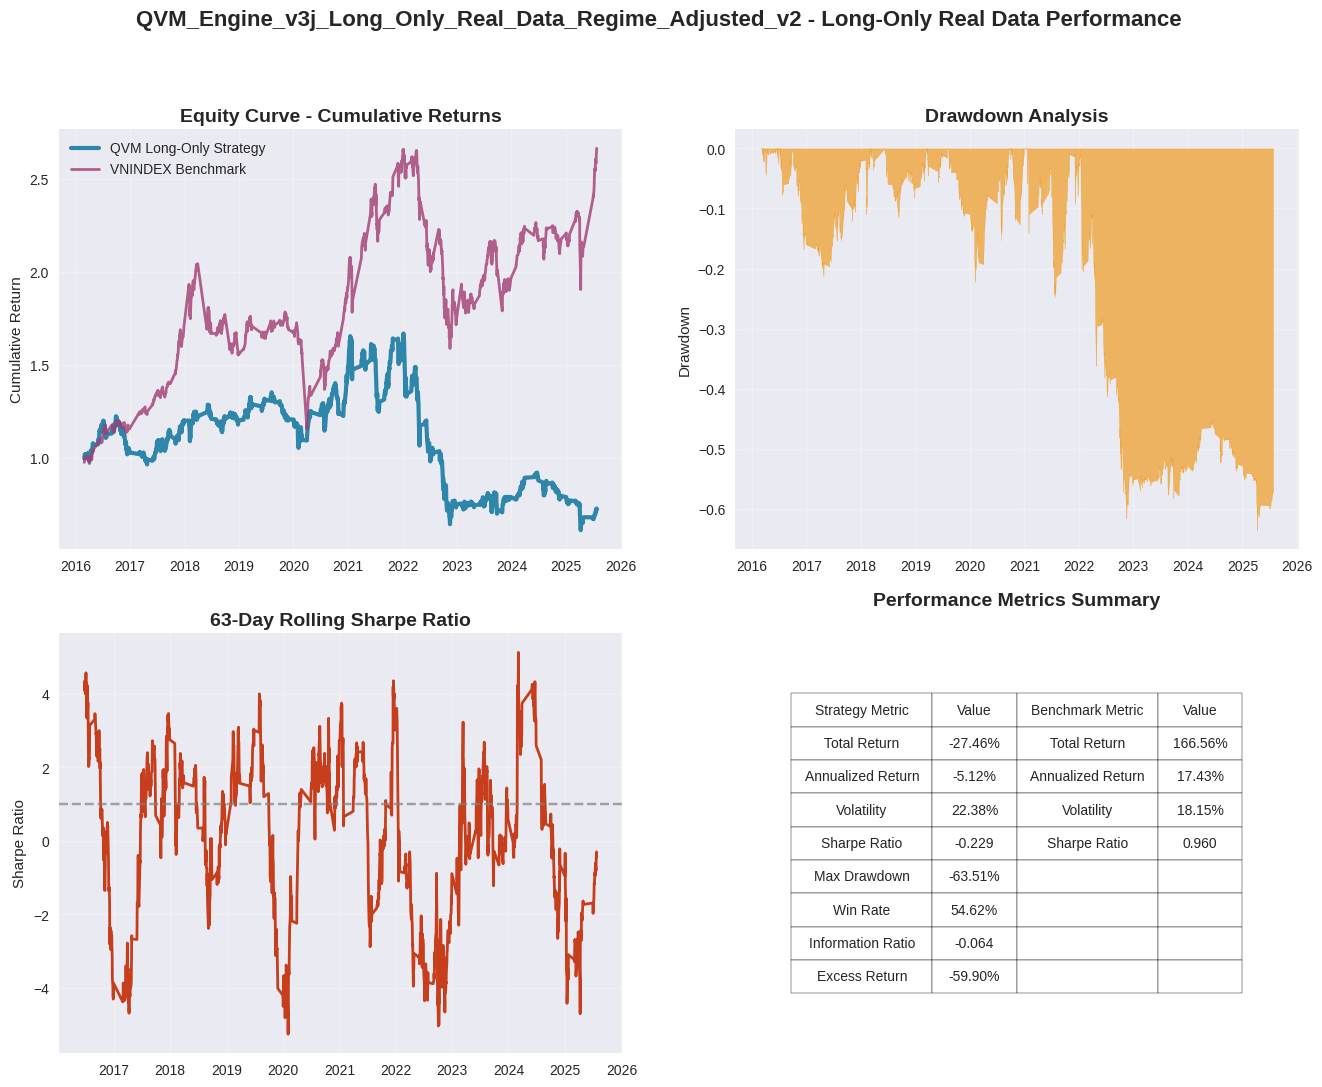

In [34]:
def main():
    """Main execution function."""
    print("🚀 QVM Engine v3j Long-Only Real Data Strategy")
    print("="*80)
    
    try:
        db_engine = create_db_connection()
        
        backtest_results, benchmark_data, daily_returns = run_long_only_backtest(QVM_CONFIG, db_engine)
        
        if backtest_results.empty or daily_returns.empty:
            print("❌ No backtest results generated")
            return
        
        metrics, performance_data = calculate_performance_metrics(backtest_results, daily_returns, benchmark_data)
        
        fig = create_equity_curve_tearsheet(backtest_results, daily_returns, benchmark_data, metrics, performance_data, QVM_CONFIG)
        
        save_results(backtest_results, daily_returns, metrics, performance_data, QVM_CONFIG)
        
        print("\n🎯 LONG-ONLY REAL DATA STRATEGY SUMMARY:")
        print(f"   - Strategy: {QVM_CONFIG['strategy_name']}")
        print(f"   - Period: {QVM_CONFIG['backtest_start_date']} to {QVM_CONFIG['backtest_end_date']}")
        print(f"   - Strategy Type: {QVM_CONFIG['strategy_type']}")
        print(f"   - Total Return: {metrics['Strategy']['Total Return']}")
        print(f"   - Annualized Return: {metrics['Strategy']['Annualized Return']}")
        print(f"   - Volatility: {metrics['Strategy']['Volatility']}")
        print(f"   - Sharpe Ratio: {metrics['Strategy']['Sharpe Ratio']}")
        print(f"   - Max Drawdown: {metrics['Strategy']['Max Drawdown']}")
        print(f"   - Excess Return vs VNINDEX: {metrics['Strategy']['Excess Return']}")
        
        print("\n✅ Long-only real data strategy completed successfully!")
        
        if fig:
            plt.show()
        
    except Exception as e:
        print(f"❌ Long-only real data strategy failed: {e}")
        import traceback
        traceback.print_exc()

# Execute the strategy
if __name__ == "__main__":
    main()